# exp041_trial

In [6]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [7]:
exp_name = 'exp041'
memo = '1st改善'

In [8]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
if MODE == "kaggle_inference":
    from cuml import ForestInference
    import treelite
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from cuml.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from unidecode import unidecode
import pykakasi

In [9]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_MODEL = "distilbert-base-multilingual-cased"
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_MODEL = "../input/distilbertbaseuncased"

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 30
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 512
NW = 2
SVD_N_COMP = 50

In [6]:
class Cat2VecModel(nn.Module):
    def __init__(self):
        super(Cat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_MODEL)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def inference(ds):
    cat2vec_model = Cat2VecModel()
    cat2vec_model = cat2vec_model.cuda()
    
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(loader):
            v = cat2vec_model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [7]:
def make_bert_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")

    cat_ds = InferenceDataset(cat_df, max_len=MAX_LEN, col=col)
    V = inference(cat_ds)
    #svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    #V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return bert_vec

In [8]:
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

def make_univ_sentence_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")
    str_array = cat_df[col].values
    embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

    embs = []
    for batch_str_array in np.array_split(str_array, 10000):
        embs.append(embedder(batch_str_array))
    V = np.vstack(embs)
    V = V.astype("float16")
    univ_sentence_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return univ_sentence_vec

In [9]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    df[["latitude", "longitude"]] = np.deg2rad(df[["latitude", "longitude"]])
    
    return df

In [10]:
def convert_unicode(df, cols):
    for c in cols:
        df.loc[df["country"]!="jp", c+"_org"] = df.loc[df["country"]!="jp", c]
        df.loc[df["country"]!="jp", c] = df.loc[df["country"]!="jp", c].apply(unidecode)
    return df

In [11]:
def convert_japanese_alphabet(df, cols):
    kakasi = pykakasi.kakasi()
    kakasi.setMode('H', 'a')  # Convert Hiragana into alphabet
    kakasi.setMode('K', 'a')  # Convert Katakana into alphabet
    kakasi.setMode('J', 'a')  # Convert Kanji into alphabet
    conversion = kakasi.getConverter()

    def convert_jp(row):
        for column in cols:
            try:
                row[column] = conversion.do(row[column])
            except:
                pass
        return row
    

    for c in cols:
        df.loc[df["country"]=="jp", c+"_org"] = df.loc[df["country"]=="jp", c]

    df[df["country"] == "jp"] = df[df["country"] == "jp"].apply(convert_jp, axis=1)
    return df

In [12]:
from cuml.feature_extraction.text import TfidfVectorizer as TfidfVectorizer_gpu
import cudf, cuml, cupy
from cuml.neighbors import NearestNeighbors as NearestNeighbors_gpu

In [13]:
def extract_candidate_dist(df):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                    metric='haversine', algorithm="brute")
        knn.fit(country_df[['latitude','longitude']], country_df.index.values)
        nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [14]:
def extract_candidate_tfidf_sim(df, col):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df[country_df[col]!="nan"].copy()
        if len(country_df) < 2:
            continue

        country_df = country_df.reset_index(drop=True)
        
        model = TfidfVectorizer(ngram_range=(3,3), analyzer="char_wb", use_idf=True)
        text_embeddings = model.fit_transform(country_df[col].tolist())

        model = NearestNeighbors_gpu(n_neighbors=min(len(country_df), N_NEIGHBORS), algorithm="brute")
        model.fit(text_embeddings)
        nears = model.kneighbors(text_embeddings, return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [15]:
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

def extract_candidate_univ_sentence_sim(df, col):
    dfs = []
    vecs = make_univ_sentence_vec(df, col)
    
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df[country_df[col]!="nan"].copy()
        if len(country_df) < 2:
            continue

        country_df = country_df.reset_index(drop=True)
        text_embeddings = np.vstack([vecs[str_] for str_ in country_df[col].values])
        
        model = NearestNeighbors_gpu(n_neighbors=min(len(country_df), N_NEIGHBORS), algorithm="brute")
        model.fit(text_embeddings)
        nears = model.kneighbors(text_embeddings, return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [16]:
def extract_candidate_bert_sim(df, col):
    dfs = []
    vecs = make_bert_vec(df,col)
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df[country_df[col]!="nan"].copy()
        if len(country_df) < 2:
            continue

        country_df = country_df.reset_index(drop=True)
        text_embeddings = np.vstack([vecs[str_] for str_ in country_df[col].values])
        
        model = NearestNeighbors_gpu(n_neighbors=min(len(country_df), N_NEIGHBORS), algorithm="brute")
        model.fit(text_embeddings)
        nears = model.kneighbors(text_embeddings, return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [17]:
def add_orgin_data(df, org_df):
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [18]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [19]:
train_origin = pd.read_csv(INPUT_DIR + "train.csv")
train_origin = preprocess(train_origin)
train_origin = convert_unicode(train_origin, ["name", "address", "city", "state"])
train_origin = convert_japanese_alphabet(train_origin, ["name", "address", "city", "state"])

# trainデータの分割
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
    train_origin = train_origin.loc[val_idx].copy()
    break
train_origin = train_origin.reset_index(drop=True)

/tmp/ipykernel_26189/375474420.py:3: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('H', 'a')  # Convert Hiragana into alphabet
/tmp/ipykernel_26189/375474420.py:4: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('K', 'a')  # Convert Katakana into alphabet
/tmp/ipykernel_26189/375474420.py:5: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('J', 'a')  # Convert Kanji into alphabet
/tmp/ipykernel_26189/375474420.py:6: DeprecationWarning: Call to deprecated method getConverter. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  conversion = kakasi.getConverter()
/tmp/ipykernel_26189/375474420.py:11: DeprecationWarning: Call to deprecated method do. (Old API will be removed in v3.0.) -- Deprecated s

In [20]:
#dist = extract_candidate_dist(train_origin)
#dist.to_feather(OUTPUT_DIR + f"{exp_name}/dist.feather")

In [21]:
#tfidf_name = extract_candidate_tfidf_sim(train_origin, "name")
#tfidf_name.to_feather(OUTPUT_DIR + f"{exp_name}/tfidf_name.feather")

In [22]:
#tfidf_address = extract_candidate_tfidf_sim(train_origin, "address")
#tfidf_address.to_feather(OUTPUT_DIR + f"{exp_name}/tfidf_address.feather")

In [23]:
#bert_name = extract_candidate_bert_sim(train_origin, "name_org")
#bert_name.to_feather(OUTPUT_DIR + f"{exp_name}/bert_name.feather")

In [24]:
#bert_address = extract_candidate_bert_sim(train_origin, "address_org")
#bert_address.to_feather(OUTPUT_DIR + f"{exp_name}/bert_address.feather")

In [25]:
#univ_name = extract_candidate_univ_sentence_sim(train_origin, "name_org")
#univ_name.to_feather(OUTPUT_DIR + f"{exp_name}/univ_name.feather")

2022-06-26 22:27:42.711681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-26 22:27:42.712304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-26 22:27:42.712598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-26 22:27:42.712795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [26]:
#univ_address = extract_candidate_univ_sentence_sim(train_origin, "address_org")
#univ_address.to_feather(OUTPUT_DIR + f"{exp_name}/univ_address.feather")

In [34]:
dist = pd.read_feather(OUTPUT_DIR + f"{exp_name}/dist.feather")
tfidf_name = pd.read_feather(OUTPUT_DIR + f"{exp_name}/tfidf_name.feather")
tfidf_address = pd.read_feather(OUTPUT_DIR + f"{exp_name}/tfidf_address.feather")
bert_name = pd.read_feather(OUTPUT_DIR + f"{exp_name}/bert_name.feather")
univ_name = pd.read_feather(OUTPUT_DIR + f"{exp_name}/univ_name.feather")

In [35]:
dist = dist.merge(train_origin[["id", "point_of_interest"]].add_prefix("match_"), on="match_id", how="left")
tfidf_name = tfidf_name.merge(train_origin[["id", "point_of_interest"]].add_prefix("match_"), on="match_id", how="left")
tfidf_address = tfidf_address.merge(train_origin[["id", "point_of_interest"]].add_prefix("match_"), on="match_id", how="left")
bert_name = bert_name.merge(train_origin[["id", "point_of_interest"]].add_prefix("match_"), on="match_id", how="left")
univ_name = univ_name.merge(train_origin[["id", "point_of_interest"]].add_prefix("match_"), on="match_id", how="left")

In [37]:
dist_Ns = []
tfidf_name_Ns = []
tfidf_address_Ns = []
bert_name_Ns = []
univ_name_Ns = []
lens = []
scores = []

In [38]:
cond = [0,5,10,20]

In [47]:
for dist_N, tfidf_name_N, tfidf_address_N, bert_name_N, univ_name_N in itertools.product(cond,cond,cond,cond,cond):
    print(dist_N, tfidf_name_N, tfidf_address_N, bert_name_N, univ_name_N)
    if dist_N + tfidf_name_N + tfidf_address_N + bert_name_N + univ_name_N == 0:
        continue

    dist_tmp = dist.groupby("id").head(dist_N)
    tfidf_name_tmp = tfidf_name.groupby("id").head(tfidf_name_N)
    tfidf_address_tmp = tfidf_address.groupby("id").head(tfidf_address_N)
    bert_name_tmp = bert_name.groupby("id").head(bert_name_N)
    univ_name_tmp = univ_name.groupby("id").head(univ_name_N)

    tmp = pd.concat([dist_tmp, tfidf_name_tmp, tfidf_address_tmp, bert_name_tmp, univ_name_tmp])
    tmp = tmp.drop_duplicates(subset=["id", "match_id"])
    tmp = tmp.reset_index(drop=True)
    print("len", len(tmp))

    score = calc_max_score(tmp, train_origin)

    dist_Ns.append(dist_N)
    tfidf_name_Ns.append(tfidf_name_N)
    tfidf_address_Ns.append(tfidf_address_N)
    bert_name_Ns.append(bert_name_N)
    univ_name_Ns.append(univ_name_N)
    lens.append(len(tmp))
    scores.append(score)

0 0 0 0 0
0 0 0 0 5
len 2846759
1st_stage_max_score : 0.83326
0 0 0 0 10
len 5692598
1st_stage_max_score : 0.85358
0 0 0 0 20
len 11382020
1st_stage_max_score : 0.87351
0 0 0 5 0
len 2846759
1st_stage_max_score : 0.82678
0 0 0 5 5
len 4577434
1st_stage_max_score : 0.85494
0 0 0 5 10
len 7211435
1st_stage_max_score : 0.86984
0 0 0 5 20
len 12707329
1st_stage_max_score : 0.88580
0 0 0 10 0
len 5692598
1st_stage_max_score : 0.84522
0 0 0 10 5
len 7220663
1st_stage_max_score : 0.86808
0 0 0 10 10
len 9348635
1st_stage_max_score : 0.87566
0 0 0 10 20
len 14593558
1st_stage_max_score : 0.88985
0 0 0 20 0
len 11382020
1st_stage_max_score : 0.86301
0 0 0 20 5
len 12732964
1st_stage_max_score : 0.88201
0 0 0 20 10
len 14619425
1st_stage_max_score : 0.88774
0 0 0 20 20
len 18976400
1st_stage_max_score : 0.89526
0 0 5 0 0
len 1853728
1st_stage_max_score : 0.74150
0 0 5 0 5
len 4606148
1st_stage_max_score : 0.86766
0 0 5 0 10
len 7436380
1st_stage_max_score : 0.88347
0 0 5 0 20
len 13107838
1st_st

In [48]:
result = pd.DataFrame()
result["dist_N"] = dist_Ns
result["tfidf_name_N"] = tfidf_name_Ns
result["tfidf_address_N"] = tfidf_address_Ns
result["bert_name_N"] = bert_name_Ns
result["univ_name_N"] = univ_name_Ns
result["len"] = lens
result["score"] = scores

In [50]:
result.to_csv(OUTPUT_DIR + f"{exp_name}/result.csv", index=False)

In [51]:
result

,dist_N,tfidf_name_N,tfidf_address_N,bert_name_N,univ_name_N,len,score
0,0,0,0,0,5,2846759,0.833258
1,0,0,0,0,5,2846759,0.833258
2,0,0,0,0,10,5692598,0.853584
3,0,0,0,0,20,11382020,0.873507
4,0,0,0,5,0,2846759,0.826784
...,...,...,...,...,...,...,...
1019,20,20,20,10,20,38466293,0.980776
1020,20,20,20,20,0,36245248,0.979763
1021,20,20,20,20,5,37167871,0.980175
1022,20,20,20,20,10,38641777,0.980521


In [52]:
# 現行スコア
dist_tmp = dist.groupby("id").head(15)
tfidf_name_tmp = tfidf_name.groupby("id").head(15)
tfidf_address_tmp = tfidf_address.groupby("id").head(0)
bert_name_tmp = bert_name.groupby("id").head(0)
univ_name_tmp = univ_name.groupby("id").head(0)

tmp = pd.concat([dist_tmp, tfidf_name_tmp, tfidf_address_tmp, bert_name_tmp, univ_name_tmp])
tmp = tmp.drop_duplicates(subset=["id", "match_id"])
tmp = tmp.reset_index(drop=True)
print("len", len(tmp))

score = calc_max_score(tmp, train_origin)

len 16556793
1st_stage_max_score : 0.97056


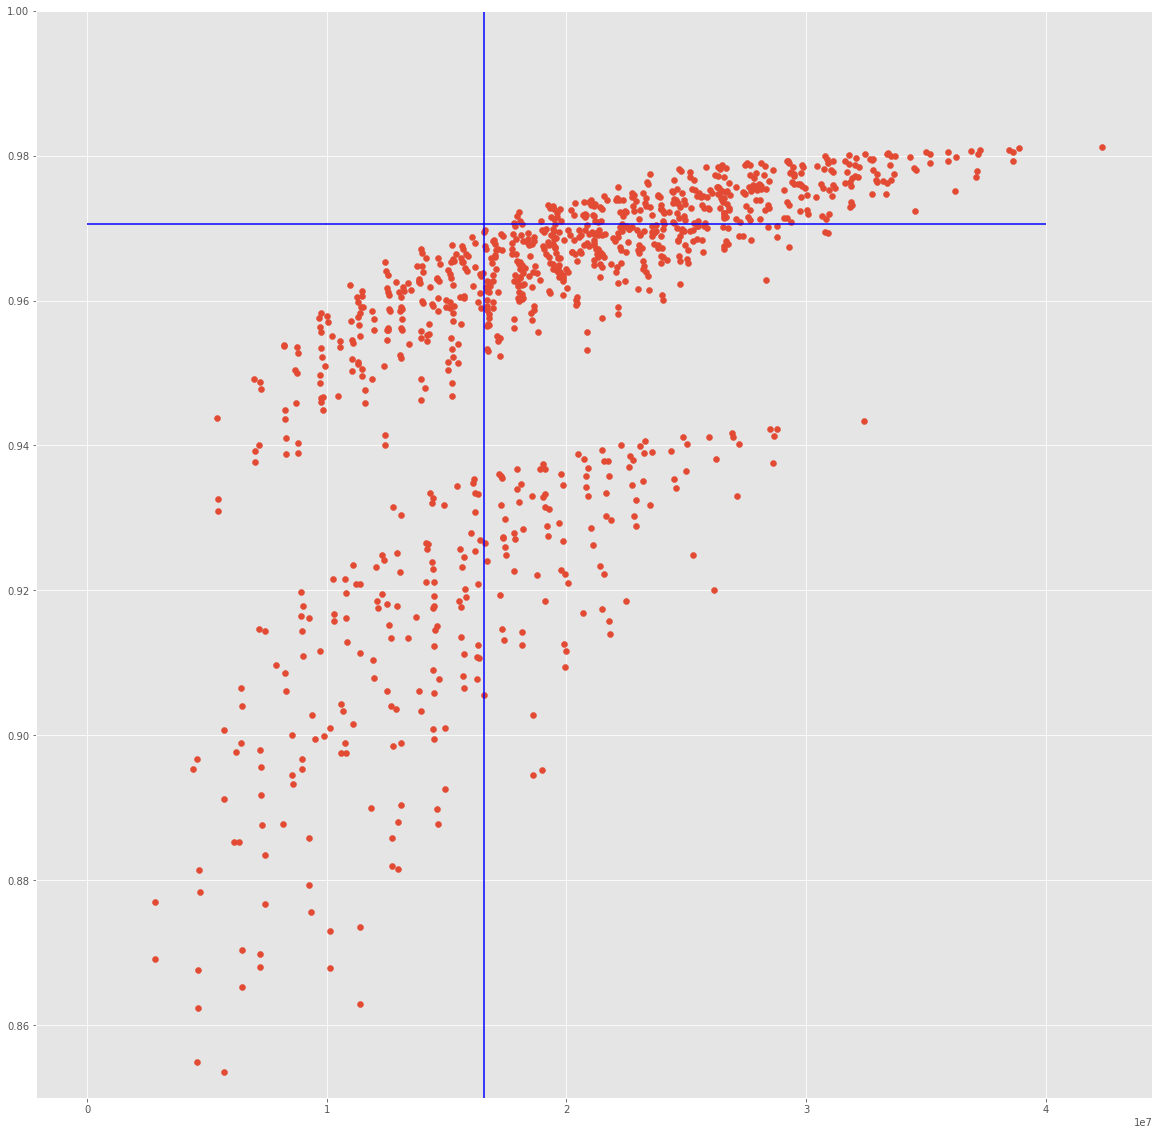

In [63]:
plt.figure(figsize=(20,20))
plt.scatter(result["len"], result["score"])
plt.ylim(0.85, 1)
plt.hlines(0.97056, xmin=0, xmax=4e7, color="b")
plt.vlines(16556793, ymin=0.85, ymax=1, color="b")

In [64]:
tmp

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,name_org,address_org,city_org,state_org,match_id,match_point_of_interest
0,E_1104d3664585a4,mama maria,0.741907,0.026620,"av. meritxell, 25",andorra la vella,parroquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",P_a12b9416902417,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,E_be8ec27bf1b71b,P_a12b9416902417
1,E_1104d3664585a4,mama maria,0.741907,0.026620,"av. meritxell, 25",andorra la vella,parroquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",P_a12b9416902417,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,E_5ccc58e81a3c11,P_ab8804cceda471
2,E_1104d3664585a4,mama maria,0.741907,0.026620,"av. meritxell, 25",andorra la vella,parroquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",P_a12b9416902417,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,E_bc8a2b3674875b,P_d872fef9bf109f
3,E_1104d3664585a4,mama maria,0.741907,0.026620,"av. meritxell, 25",andorra la vella,parroquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",P_a12b9416902417,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,E_4a34a5012e88c3,P_15f4dafd9cc0f4
4,E_1104d3664585a4,mama maria,0.741907,0.026620,"av. meritxell, 25",andorra la vella,parroquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",P_a12b9416902417,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,E_c93b28d5249c89,P_c6e577d6c015b1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16556788,E_ffe72b9f8b2dd4,pick n pay centurion,-0.451303,0.491936,heuwel st,centurion,gauteng,0157,za,http://www.pnp.co.za,+27126631125,"convenience stores, supermarkets, grocery stores",P_0bf866f86301de,pick n pay centurion,heuwel st,centurion,gauteng,E_c66b51f4334977,P_89b89dcae40b57
16556789,E_ffe72b9f8b2dd4,pick n pay centurion,-0.451303,0.491936,heuwel st,centurion,gauteng,0157,za,http://www.pnp.co.za,+27126631125,"convenience stores, supermarkets, grocery stores",P_0bf866f86301de,pick n pay centurion,heuwel st,centurion,gauteng,E_f2d0d60b4add48,P_843a3d21571637
16556790,E_ffe72b9f8b2dd4,pick n pay centurion,-0.451303,0.491936,heuwel st,centurion,gauteng,0157,za,http://www.pnp.co.za,+27126631125,"convenience stores, supermarkets, grocery stores",P_0bf866f86301de,pick n pay centurion,heuwel st,centurion,gauteng,E_a46ea6b4292c8b,P_12f6ed4f3d668e
16556791,E_ffe72b9f8b2dd4,pick n pay centurion,-0.451303,0.491936,heuwel st,centurion,gauteng,0157,za,http://www.pnp.co.za,+27126631125,"convenience stores, supermarkets, grocery stores",P_0bf866f86301de,pick n pay centurion,heuwel st,centurion,gauteng,E_445e54b7c06036,P_40ad6fe0dc7427


In [65]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c

In [76]:
conds = []
ths = []
lens = []
scores = []

In [77]:
cond = "dist15+tfidf_name15"
# 現行スコア
dist_tmp = dist.groupby("id").head(15)
tfidf_name_tmp = tfidf_name.groupby("id").head(15)
tmp = pd.concat([dist_tmp, tfidf_name_tmp])
tmp = tmp.drop_duplicates(subset=["id", "match_id"])
tmp = tmp.reset_index(drop=True)
tmp = tmp.merge(train_origin[["id", "longitude", "latitude"]].add_prefix("match_"), on="match_id")
tmp["habersine_dist"] = haversine_np(tmp["longitude"], tmp["latitude"], tmp["match_longitude"], tmp["match_latitude"])

for th in [0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02,0.01]:
    print(th)
    tmp2 = tmp[tmp["habersine_dist"]<th].copy()
    tmp2 = tmp2.reset_index(drop=True)
    print("len", len(tmp2))
    score = calc_max_score(tmp2, train_origin)
    conds.append(cond)
    ths.append(th)
    lens.append(len(tmp2))
    scores.append(score)

0.5
len 16226389
1st_stage_max_score : 0.97052
0.4
len 16004821
1st_stage_max_score : 0.97049
0.3
len 15686492
1st_stage_max_score : 0.97043
0.2
len 15068363
1st_stage_max_score : 0.97029
0.1
len 13823661
1st_stage_max_score : 0.96997
0.08
len 13366811
1st_stage_max_score : 0.96984
0.06
len 12781409
1st_stage_max_score : 0.96964
0.04
len 12053531
1st_stage_max_score : 0.96940
0.02
len 11338636
1st_stage_max_score : 0.96886
0.01
len 10780814
1st_stage_max_score : 0.96775


In [78]:
cond = "dist20+tfidf_name20"
# 現行スコア
dist_tmp = dist.groupby("id").head(20)
tfidf_name_tmp = tfidf_name.groupby("id").head(20)
tmp = pd.concat([dist_tmp, tfidf_name_tmp])
tmp = tmp.drop_duplicates(subset=["id", "match_id"])
tmp = tmp.reset_index(drop=True)
tmp = tmp.merge(train_origin[["id", "longitude", "latitude"]].add_prefix("match_"), on="match_id")
tmp["habersine_dist"] = haversine_np(tmp["longitude"], tmp["latitude"], tmp["match_longitude"], tmp["match_latitude"])

for th in [0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02,0.01]:
    print(th)
    tmp2 = tmp[tmp["habersine_dist"]<th].copy()
    tmp2 = tmp2.reset_index(drop=True)
    print("len", len(tmp2))
    score = calc_max_score(tmp2, train_origin)
    conds.append(cond)
    ths.append(th)
    lens.append(len(tmp2))
    scores.append(score)

0.5
len 21693744
1st_stage_max_score : 0.97560
0.4
len 21392110
1st_stage_max_score : 0.97556
0.3
len 20958958
1st_stage_max_score : 0.97549
0.2
len 20117099
1st_stage_max_score : 0.97533
0.1
len 18420776
1st_stage_max_score : 0.97497
0.08
len 17798246
1st_stage_max_score : 0.97483
0.06
len 16999338
1st_stage_max_score : 0.97461
0.04
len 16007647
1st_stage_max_score : 0.97434
0.02
len 15031854
1st_stage_max_score : 0.97377
0.01
len 14260700
1st_stage_max_score : 0.97261


In [79]:
cond = "dist30+tfidf_name30"
# 現行スコア
dist_tmp = dist.groupby("id").head(30)
tfidf_name_tmp = tfidf_name.groupby("id").head(30)
tmp = pd.concat([dist_tmp, tfidf_name_tmp])
tmp = tmp.drop_duplicates(subset=["id", "match_id"])
tmp = tmp.reset_index(drop=True)
tmp = tmp.merge(train_origin[["id", "longitude", "latitude"]].add_prefix("match_"), on="match_id")
tmp["habersine_dist"] = haversine_np(tmp["longitude"], tmp["latitude"], tmp["match_longitude"], tmp["match_latitude"])

for th in [0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02,0.01]:
    print(th)
    tmp2 = tmp[tmp["habersine_dist"]<th].copy()
    tmp2 = tmp2.reset_index(drop=True)
    print("len", len(tmp2))
    score = calc_max_score(tmp2, train_origin)
    conds.append(cond)
    ths.append(th)
    lens.append(len(tmp2))
    scores.append(score)

0.5
len 31551974
1st_stage_max_score : 0.98103
0.4
len 31101521
1st_stage_max_score : 0.98099
0.3
len 30453486
1st_stage_max_score : 0.98091
0.2
len 29200923
1st_stage_max_score : 0.98073
0.1
len 26684105
1st_stage_max_score : 0.98031
0.08
len 25758928
1st_stage_max_score : 0.98015
0.06
len 24569894
1st_stage_max_score : 0.97991
0.04
len 23096374
1st_stage_max_score : 0.97962
0.02
len 21638355
1st_stage_max_score : 0.97901
0.01
len 20462331
1st_stage_max_score : 0.97779


In [80]:
result2 = pd.DataFrame()
result2["cond"] = conds
result2["th"] = ths
result2["len"] = lens
result2["score"] = scores

In [82]:
result2.to_csv(OUTPUT_DIR + f"{exp_name}/result2.csv", index=False)

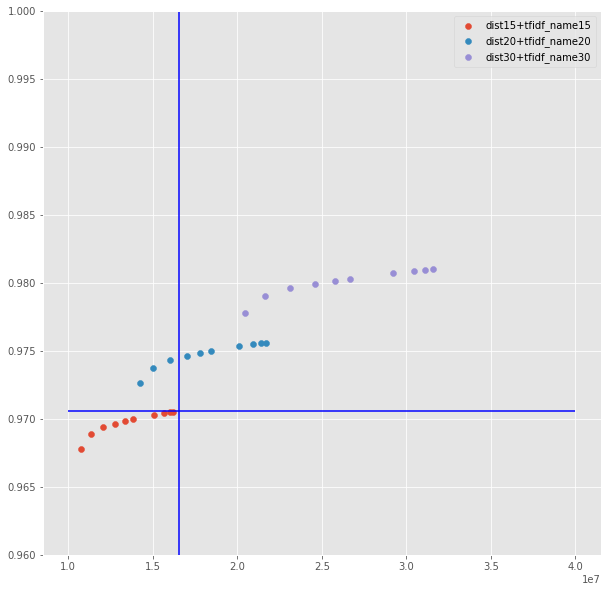

In [85]:
plt.figure(figsize=(10,10))
plt.scatter(result2[result2["cond"]=="dist15+tfidf_name15"]["len"], result2[result2["cond"]=="dist15+tfidf_name15"]["score"], label="dist15+tfidf_name15")
plt.scatter(result2[result2["cond"]=="dist20+tfidf_name20"]["len"], result2[result2["cond"]=="dist20+tfidf_name20"]["score"], label="dist20+tfidf_name20")
plt.scatter(result2[result2["cond"]=="dist30+tfidf_name30"]["len"], result2[result2["cond"]=="dist30+tfidf_name30"]["score"], label="dist30+tfidf_name30")
plt.legend()
plt.ylim(0.96, 1)
plt.hlines(0.97056, xmin=1e7, xmax=4e7, color="b")
plt.vlines(16556793, ymin=0.96, ymax=1, color="b")

In [10]:
result2 = pd.read_csv(OUTPUT_DIR + f"{exp_name}/result2.csv")

In [12]:
result2[(result2["len"]<16556793)&(result2["score"]>0.97056)]

,cond,th,len,score
17,dist20+tfidf_name20,0.04,16007647,0.974343
18,dist20+tfidf_name20,0.02,15031854,0.973770
19,dist20+tfidf_name20,0.01,14260700,0.972609
